In [1]:
!pip install /Users/johnmount/Documents/work/pyvtreat/pkg/dist/vtreat-0.1.tar.gz
#!pip install https://github.com/WinVector/pyvtreat/raw/master/pkg/dist/vtreat-0.1.tar.gz

Processing /Users/johnmount/Documents/work/pyvtreat/pkg/dist/vtreat-0.1.tar.gz
  Stored in directory: /Users/johnmount/Library/Caches/pip/wheels/cf/06/fc/6b2552717486fb6401f19308eec24381555e456e3bd9cfb103
Successfully built vtreat
  Found existing installation: vtreat 0.1
    Uninstalling vtreat-0.1:
      Successfully uninstalled vtreat-0.1


In [2]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re

In [3]:
n_rows = 2000
n_signal_variables = 2
n_noise_variables = 2
n_levels = 500

In [4]:
d = pandas.DataFrame({"y":numpy.random.normal(size = n_rows)})

In [5]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.normal(size=1)[0]
    return values

In [6]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [7]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [8]:
d.head()

,y,var_0,var_1,noise_0,noise_1
0,0.325557,level_275,level_137,level_80,level_368
1,-1.786793,level_12,level_63,level_258,level_294
2,-1.196302,level_340,level_181,level_235,level_88
3,2.135385,level_190,level_294,level_476,level_355
4,1.494962,level_14,level_19,level_87,level_144


In [9]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [10]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [11]:
plan = vtreat.NumericOutcomeTreatment()

In [12]:
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train = plan.transform(d_train)

In [13]:
cross_frame.head()

,var_0_impact_code,var_0_deviance_code,var_0_prevalence_code,var_1_impact_code,var_1_deviance_code,var_1_prevalence_code,noise_0_impact_code,noise_0_deviance_code,noise_0_prevalence_code,noise_1_impact_code,noise_1_deviance_code,noise_1_prevalence_code
0,0.000000,1.465619,0.000987,0.000000,0.000000,0.000000,-0.076087,1.485839,0.004936,0.000000e+00,1.772358,0.001974
1,-0.023919,3.338983,0.002962,0.000000,1.417473,0.000987,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2,0.417644,1.181621,0.002962,-1.693888,1.075977,0.002962,0.000000,1.760554,0.000987,0.000000e+00,1.827620,0.000987
3,0.000000,1.481177,0.001974,0.000000,0.000000,0.000987,-0.201414,0.803523,0.002962,-2.775558e-17,1.810779,0.000987
4,0.256809,3.284083,0.002962,0.000000,0.000000,0.000987,0.000000,1.760554,0.000987,0.000000e+00,1.827620,0.000987


In [14]:
naive_train.head()

,var_0_impact_code,var_0_deviance_code,var_0_prevalence_code,var_1_impact_code,var_1_deviance_code,var_1_prevalence_code,noise_0_impact_code,noise_0_deviance_code,noise_0_prevalence_code,noise_1_impact_code,noise_1_deviance_code,noise_1_prevalence_code
0,-0.958795,0.138794,0.000987,0.000000,1.401808,0.000000,-2.120027e-01,1.386805,0.004936,-7.412084e-01,0.312062,0.001974
1,0.069240,2.468868,0.002962,2.377091,0.400930,0.000987,2.775558e-17,1.747047,0.000000,2.775558e-17,1.773680,0.000000
2,-0.158259,1.821664,0.002962,-2.011328,0.937180,0.002962,-1.207743e+00,1.110955,0.000987,-1.424567e-02,3.734444,0.000987
3,-0.206613,2.630248,0.001974,-0.410849,1.445101,0.000987,-5.533702e-01,1.019762,0.002962,-2.463077e-01,1.672574,0.000987
4,0.709177,2.910195,0.002962,-0.782650,2.165695,0.000987,1.806865e-01,2.222781,0.000987,-8.244202e-01,1.627819,0.000987


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_correlation"] = [ 
    scipy.stats.pearsonr(naive_train[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.658869,0.278300,0.348616,False
1,var_1_impact_code,0.685949,0.323724,0.338967,False
2,noise_0_impact_code,0.511079,0.006651,0.034920,True
3,noise_1_impact_code,0.502374,-0.015379,0.038921,True


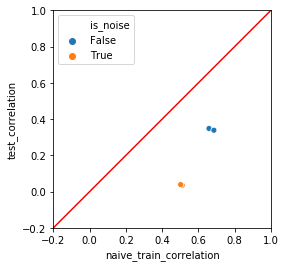

In [16]:
seaborn.scatterplot(x = "naive_train_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

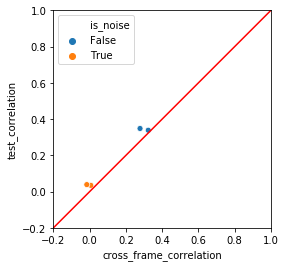

In [17]:
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [18]:
plan.score_frame_.tail()

,variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
7,noise_0_deviance_code,deviance_code,True,True,-0.000713,0.981911,4.0,False
8,noise_0_prevalence_code,prevalence_code,False,True,-0.016386,0.602430,4.0,False
9,noise_1_impact_code,impact_code,True,True,-0.015379,0.624906,4.0,False
10,noise_1_deviance_code,deviance_code,True,True,-0.059509,0.058310,4.0,False
11,noise_1_prevalence_code,prevalence_code,False,True,-0.021954,0.485201,4.0,False


In [19]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code', 'var_0_deviance_code', 'var_1_impact_code']

In [20]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [21]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [22]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [23]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [24]:
fitter.fit(naive_train[all_vars], y_train)
plot_train["predict_naive_all_vars"] = fitter.predict(naive_train[all_vars])
plot_test["predict_naive_all_vars"] = fitter.predict(prepared_test[all_vars])

In [25]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_all_vars
0,0.325557,-1.807713,-1.690374,-1.576917
1,-1.786793,-0.152218,-0.272320,-0.360818
2,1.494962,0.273677,0.190411,0.996678
3,-0.674012,0.629003,0.513578,0.849149
4,-3.502033,-2.990283,-3.131341,-3.073413


In [26]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

0.9265094741675182


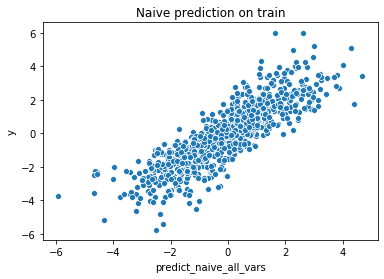

In [27]:
print(rmse(plot_train["predict_naive_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive prediction on train")

1.5987571274886379


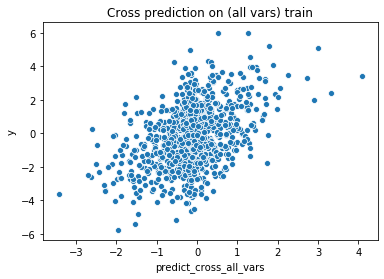

In [28]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

1.6038337877439488


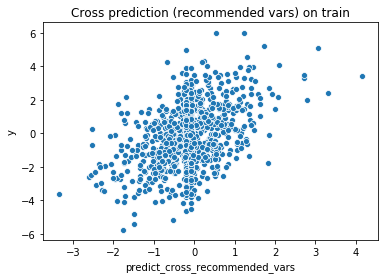

In [29]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

1.5229296062931856



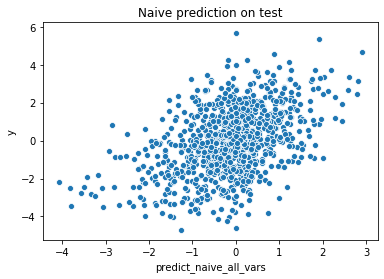

In [30]:
print(rmse(plot_test["predict_naive_all_vars"], plot_test["y"]))
print()
seaborn.scatterplot(x="predict_naive_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive prediction on test")

1.4897823593842137


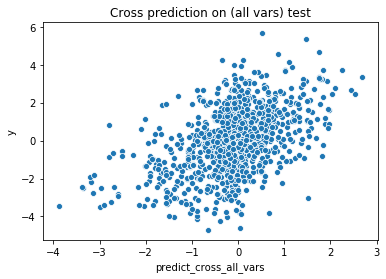

In [31]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

1.4883058933560558


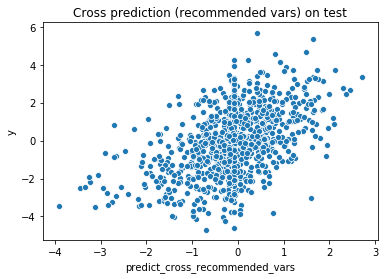

In [32]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [33]:
smf = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train[all_vars])).fit()
smf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     222.1
Date:                Thu, 25 Jul 2019   Prob (F-statistic):          5.20e-272
Time:                        12:25:52   Log-Likelihood:                -1360.1
No. Observations:                1013   AIC:                             2746.
Df Residuals:                    1000   BIC:                             2810.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.3656      0.131     -2.797      0.005      -0.622      -0.109
var_0_impact_code           0.7547      0.036     21.036      0.000       0.684       0.825
var_0_deviance_code         0.0644      0.047      1.380      0.168      -0.027       0.156
var_0_prevalence_code      -2.3682     21.316     -0.111      0.912     -44.197      39.460
var_1_impact_code           0.7468      0.035     21.319      0.000       0.678       0.816
var_1_deviance_code         0.0340      0.044      0.765      0.445      -0.053       0.121
var_1_prevalence_code     -19.3612     22.526     -0.860      0.390     -63.565      24.842
noise_0_impact_code         0.4236      0.052      8.168      0.000       0.322       0.525
noise_0_deviance_code       0.0927      0.039      2.358      0.019       0.016       0.170
noise_0_prevalence_code    -7.0142     21.107     -0.332      0.740     -48.433      34.405
noise_1_impact_code         0.5698      0.050     11.311      0.000       0.471       0.669
noise_1_deviance_code       0.0314      0.037      0.859      0.390      -0.040       0.103
noise_1_prevalence_code     4.5312     21.226      0.213      0.831     -37.122      46.184
==============================================================================
Omnibus:                       27.863   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.895
Skew:                           0.057   Prob(JB):                     3.63e-14
Kurtosis:                       4.206   Cond. No.                     2.43e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
smf = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     19.23
Date:                Thu, 25 Jul 2019   Prob (F-statistic):           5.28e-38
Time:                        12:25:52   Log-Likelihood:                -1912.7
No. Observations:                1013   AIC:                             3851.
Df Residuals:                    1000   BIC:                             3915.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.1733      0.179     -0.968      0.333      -0.525       0.178
var_0_impact_code           0.7106      0.074      9.661      0.000       0.566       0.855
var_0_deviance_code         0.0638      0.070      0.917      0.359      -0.073       0.200
var_0_prevalence_code      21.0332     39.716      0.530      0.597     -56.903      98.969
var_1_impact_code           0.7870      0.071     11.063      0.000       0.647       0.927
var_1_deviance_code         0.1024      0.071      1.440      0.150      -0.037       0.242
var_1_prevalence_code      -9.8758     40.858     -0.242      0.809     -90.053      70.302
noise_0_impact_code        -0.0353      0.104     -0.338      0.735      -0.240       0.169
noise_0_deviance_code       0.0144      0.060      0.242      0.809      -0.102       0.131
noise_0_prevalence_code   -26.4425     39.727     -0.666      0.506    -104.401      51.516
noise_1_impact_code         0.0795      0.105      0.760      0.448      -0.126       0.285
noise_1_deviance_code      -0.0973      0.059     -1.655      0.098      -0.213       0.018
noise_1_prevalence_code    13.4204     39.578      0.339      0.735     -64.246      91.087
==============================================================================
Omnibus:                        0.270   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.874   Jarque-Bera (JB):                0.311
Skew:                           0.038   Prob(JB):                        0.856
Kurtosis:                       2.959   Cond. No.                     2.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
params = {'use_hierarchical_estimate':True}
params

{'use_hierarchical_estimate': True}